   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2022, MBARI</div>
    
  * Distributed under the terms of the GPL License
  * Maintainer: dcline@mbari.org
  * Authors: Danelle Cline dcline@mbari.org, John Ryan ryjo@mbari.org

## Basic Exploration of the 256 kHz Pacific Ocean Audio Data in the AWS Open Data Registry

---
An extensive (5+ years and growing) archive of sound recordings from a deep-sea location [along the eastern margin of the North Pacific Ocean](https://www.mbari.org/at-sea/cabled-observatory/) has been made available through AWS Open data.  Temporal coverage of the recording archive has been 95% since project inception in July 2015.  The original recordings have a sample rate of 256 kHz.  This notebook illustrates basic methods to access and process the original audio data using Python.

If you use this data set, please **[cite our project](https://ieeexplore.ieee.org/document/7761363).**

 <div style="text-align: center">
 <h3>A delayed version of this data can be heard here on this live audio station</h3>
 <audio controls>
 <source src="http://listen.shoutcast.com/oceansoundscape" type="audio/mpeg">
 Your browser does not support the audio player to play the live stream from Monterey Bay  </audio>
</div>

## Data Overview
The full-resolution audio data are in [WAV](https://en.wikipedia.org/wiki/WAV) format in s3 buckets named <b>pacific-sound-256khz-yyyy</b>, where yyyy is 2015 or later.  Buckets are stored as objects, so the data aren't physically stored in folders or directories as you may be famaliar with, but you can think of it conceptually as follows:

```
pacific-sound-256khz-2021
      |
      individual 10-minute files
```


## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [1]:
!pip install -q boto3
!pip install -q soundfile
!pip install -q scipy
!pip install -q numpy
!pip install -q matplotlib

     |████████████████████████████████| 132 kB 15.0 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 9.2 MB 73.3 MB/s 
     |████████████████████████████████| 140 kB 82.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


### Import all packages

In [2]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal, interpolate
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

## List the contents of a monthly directory

In [3]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='', 
    config=Config(signature_version=UNSIGNED))

In [4]:
bucket = 'pacific-sound-256khz-2018'

for i, obj in enumerate(s3.list_objects_v2(Bucket=bucket)['Contents']):
  print(obj['Key'])
  if i > 20:
      break

01/MARS_20180101_000406.wav
01/MARS_20180101_001406.wav
01/MARS_20180101_002406.wav
01/MARS_20180101_003406.wav
01/MARS_20180101_004406.wav
01/MARS_20180101_005406.wav
01/MARS_20180101_010406.wav
01/MARS_20180101_011406.wav
01/MARS_20180101_012406.wav
01/MARS_20180101_013406.wav
01/MARS_20180101_014406.wav
01/MARS_20180101_015406.wav
01/MARS_20180101_020406.wav
01/MARS_20180101_021406.wav
01/MARS_20180101_022406.wav
01/MARS_20180101_023406.wav
01/MARS_20180101_024406.wav
01/MARS_20180101_025406.wav
01/MARS_20180101_030406.wav
01/MARS_20180101_031406.wav
01/MARS_20180101_032406.wav
01/MARS_20180101_033406.wav


## Read metadata from a file

In [5]:
bucket = 'pacific-sound-256khz-2018'
filename = '01/MARS_20180101_092406.wav'
url = f'https://{bucket}.s3.amazonaws.com/{filename}'
print(f'Reading metadata from {url}')
sf.info(io.BytesIO(urlopen(url).read()), verbose=True) 

Reading metadata from https://pacific-sound-256khz-2018.s3.amazonaws.com/01/MARS_20180101_092406.wav


samplerate: 256000 Hz
channels: 1
duration: 1e+01:0.000 min
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]
endian: FILE
sections: 1
frames: 153600000
extra_info: """
    Length : 460800356
    RIFF : 460800348
    WAVE
    LIST : 304
      INFO
        IART : icListen HF #1689
        IPRD : RB9-ETH R4
        ICRD : 2018-01-01T01:24:06-08
        ISFT : Lucy V4.3.0
        INAM : MARS_20180101_092406.wav
        ICMT : 3.000000 V pk, -177 dBV re 1uPa, 38.6 % RH,  6.1 deg C, 8388608 = Max Count
    fmt  : 16
      Format        : 0x1 => WAVE_FORMAT_PCM
      Channels      : 1
      Sample Rate   : 256000
      Block Align   : 3
      Bit Width     : 24
      Bytes/sec     : 768000
    data : 460800000
    End
    """

## Read data from a file

In [6]:
print(f'Reading data from {url}')
x, sample_rate = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32')

Reading data from https://pacific-sound-256khz-2018.s3.amazonaws.com/01/MARS_20180101_092406.wav


### Calibrated Spectrum Levels

### Calibration metadata
Frequency-dependent hydrophone sensitivity data are defined in the following files, one for each deployment:
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json

### Compute spectrogram




In [7]:
# convert scaled voltage to volts
v = x*3 
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 1  # seconds per average
nseg = int(nsec/spa)
print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')

600 segments of length 1 seconds in 600.0 seconds of audio


In [8]:
# initialize empty LTSA
nfreq = int(sample_rate/2+1)
nfreq,nseg
sg = np.empty((nfreq, nseg), float)
sg.shape

(128001, 600)

In [9]:
# get window for welch
w = scipy.signal.get_window('hann',sample_rate)

# process spectrogram
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
  f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
  psd = 10*np.log10(psd)
  sg[:,x] = psd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


### Apply calibration
Frequency-dependent hydrophone sensitivity data are reported in the json files identified above.  This example file is from the second hydrophone deployment, for which the calibration data are manually entered below.  Note that the lowest measured value, at 250 Hz, is assumed to cover lower frequencies and repeated as a value at 0 Hz to allow interpolation to the spectrogram output frequencies across the full frequency range. 



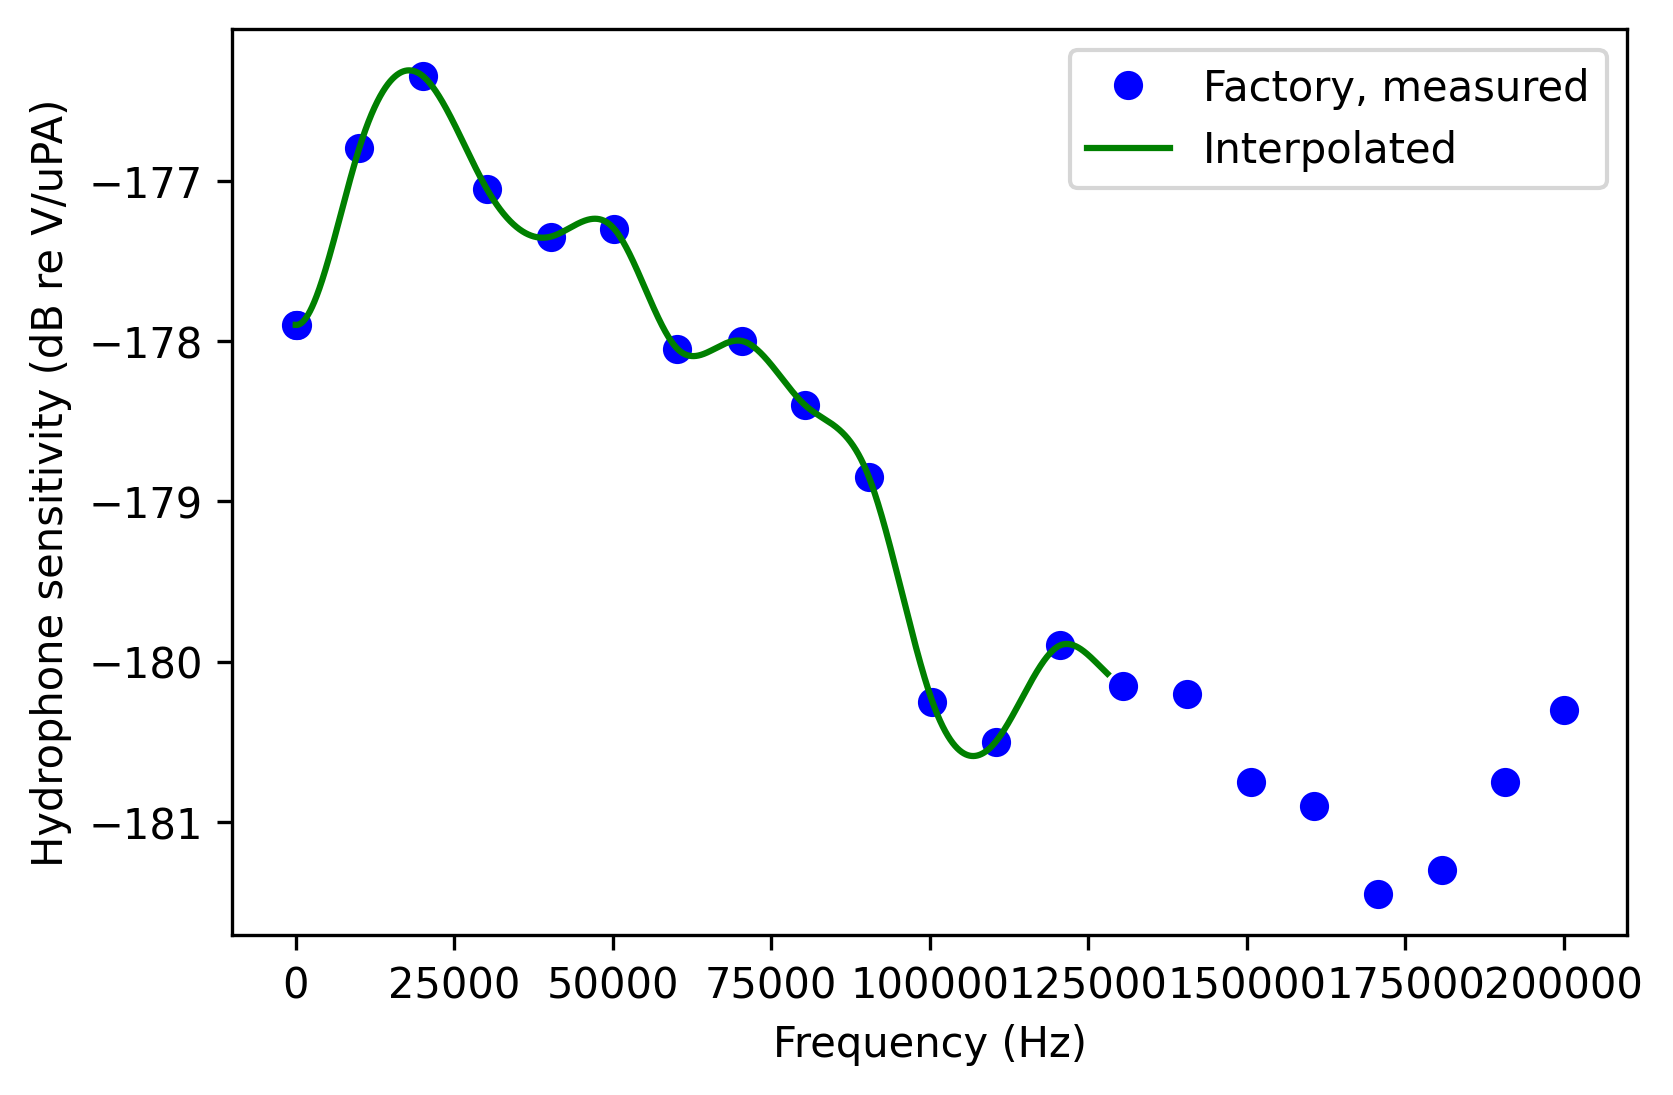

In [10]:
# define hydrophone calibration data
calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

# interpolate to the frequency resolution of the spectrogram
tck = interpolate.splrep(calfreq, calsens, s=0)
isens = interpolate.splev(f, tck, der=0)
plt.figure(dpi=300)
im = plt.plot(calfreq,calsens,'bo',f,isens,'g') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hydrophone sensitivity (dB re V/uPA)')
plt.legend(['Factory, measured', 'Interpolated'])


In [11]:
# replicate interpolated sensitivity
isensg = np.transpose(np.tile(isens,[nseg,1]))
isensg.shape

(128001, 600)

In [12]:
sg.shape

(128001, 600)

### Plot the calibrated spectrogram

Text(0.5, 1.0, 'Calibrated spectrum levels')

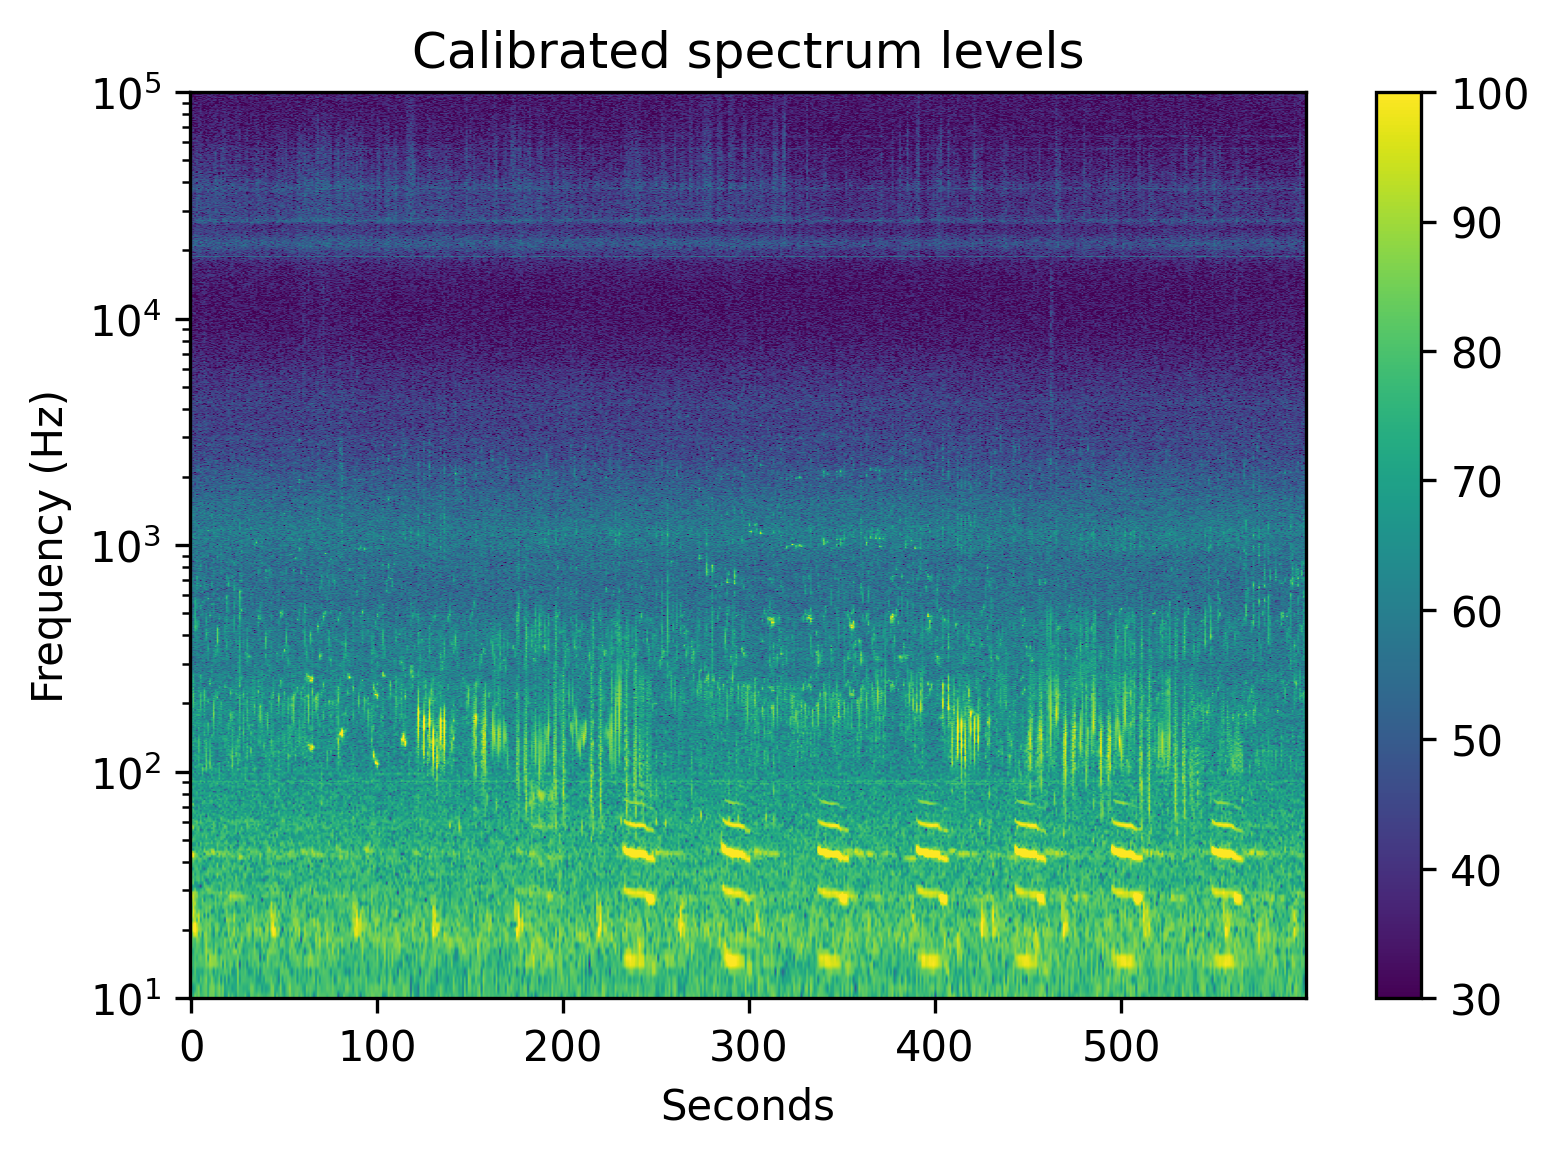

In [13]:
plt.figure(dpi=300)
im = plt.imshow(sg-isensg,aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,100000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')